In [120]:
library(fGarch)
library(ppcor)

In [211]:
data = read.csv("./Data/num_colos_new.csv")
# the raw data is without diff, need to perform diff for filtering!

In [212]:
head(data)

,X,X..arsenic...,X..copper...,X..sulfate...,X..boran...,X..chloride...,X..arsenic....copper..,X..arsenic....sulfate..,X..arsenic....boran..,X..arsenic....chloride..,X..copper....boran..,X..sulfate....boran..,X..boran....chloride..,X..arsenic....copper....boran..,X..arsenic....sulfate....boran..,X..arsenic....boran....chloride..
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,2,0,1,1,0,0,1,1,0,0,0,0,0,0,0
2,1,7,4,2,7,0,4,2,7,0,4,2,0,4,2,0
3,2,6,3,2,5,1,3,2,5,1,3,2,1,3,2,1
4,3,3,0,2,1,0,0,2,1,0,0,0,0,0,0,0
5,4,4,3,2,2,2,3,2,2,2,2,2,2,2,2,2
6,5,4,0,2,1,0,0,2,1,0,0,0,0,0,0,0


In [226]:
vw = data[,5]

In [227]:
head(vw)

[1] 1 7 5 1 2 1

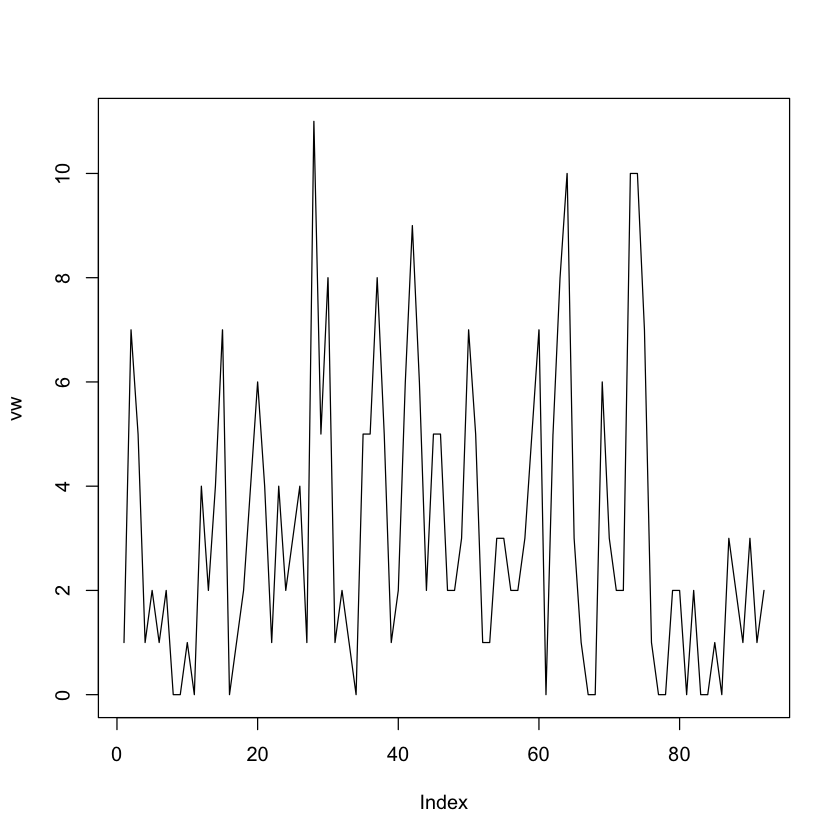

In [228]:
plot(vw,type = "l")

In [229]:
z = diff(vw)

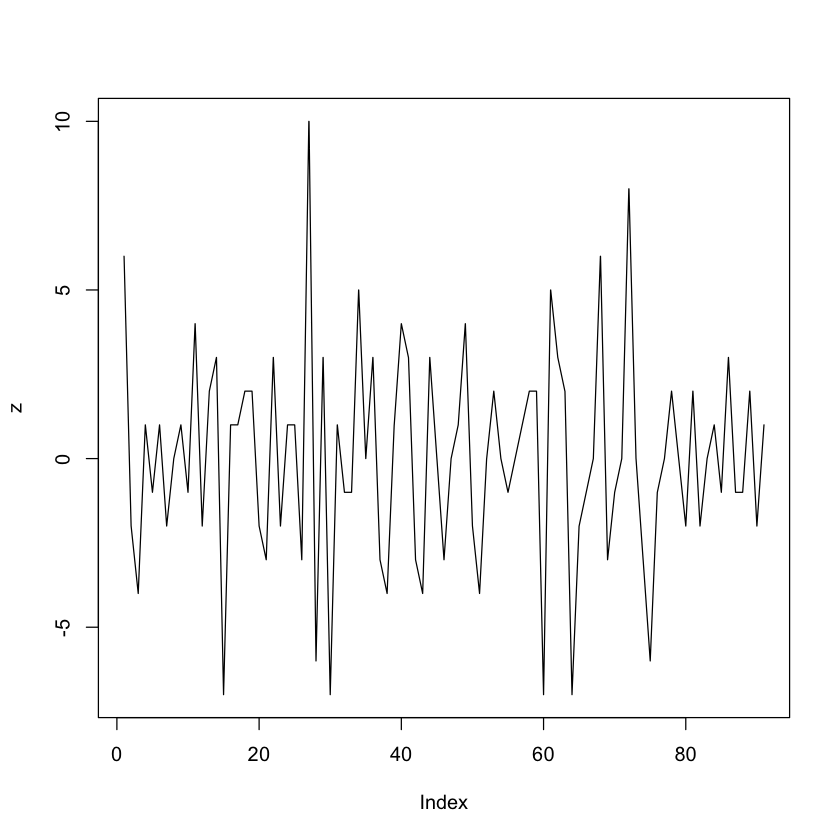

In [230]:
plot(z,type = "l")

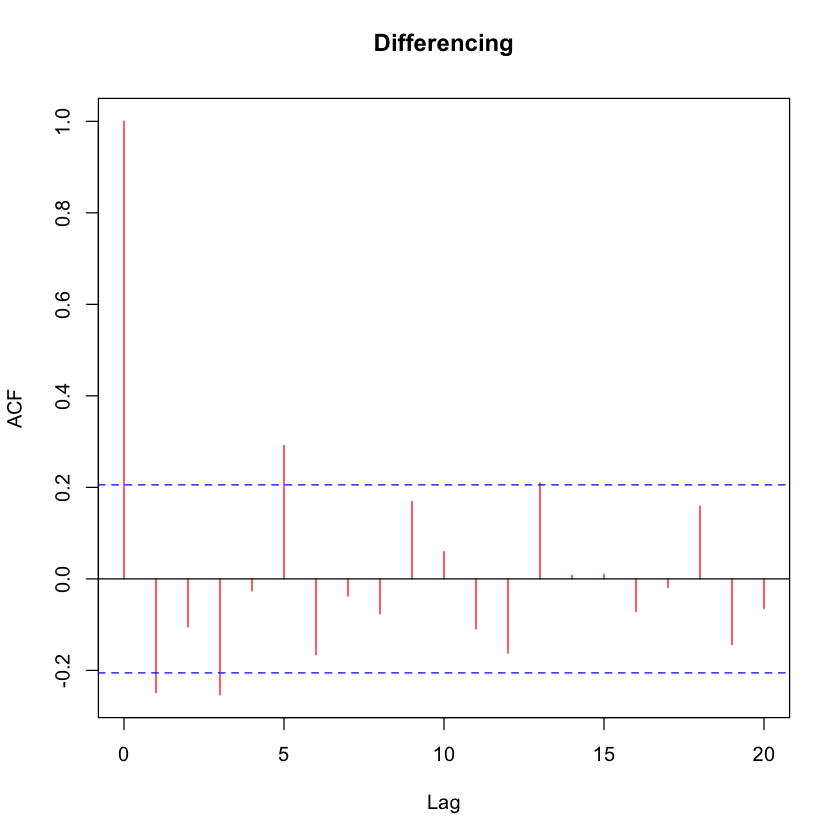

In [231]:
acf(z,20,main= "Differencing" ,col="red")

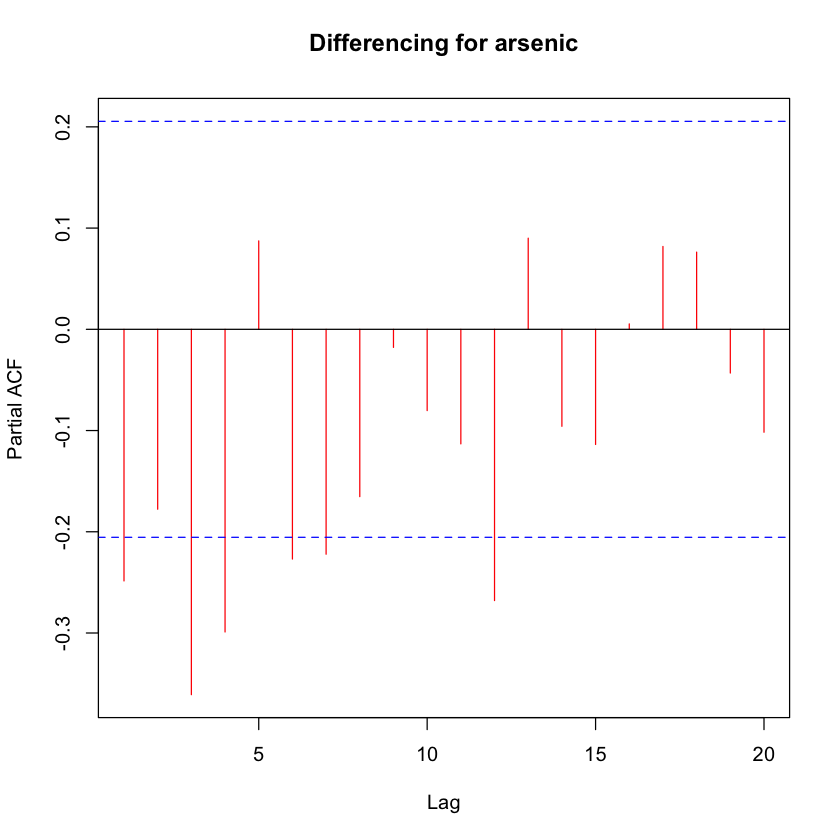

In [232]:
pacf(z,20,main= "Differencing for arsenic",col="red")

In [245]:
m1 <- arima(z,order = c(4,0,3),fixed = c(NA,NA,0,NA,0,0,NA,NA))
m1

Warning message in arima(z, order = c(4, 0, 3), fixed = c(NA, NA, 0, NA, 0, 0, NA, :
“some AR parameters were fixed: setting transform.pars = FALSE”



Call:
arima(x = z, order = c(4, 0, 3), fixed = c(NA, NA, 0, NA, 0, 0, NA, NA))

Coefficients:
          ar1      ar2  ar3      ar4  ma1  ma2      ma3  intercept
      -0.5301  -0.5036    0  -0.1825    0    0  -0.7031    -0.0066
s.e.   0.1024   0.1255    0   0.0915    0    0   0.0971     0.0390

sigma^2 estimated as 6.318:  log likelihood = -213.89,  aic = 439.77

In [246]:
Box.test(m1$residuals,lag=12,type="Ljung")


	Box-Ljung test

data:  m1$residuals
X-squared = 8.2013, df = 12, p-value = 0.7692


In [247]:
df <- 12-4
chi <- Box.test(m1$residuals,lag=12,type="Ljung")$statistic
pv=1-pchisq(chi,df) #Compute p-value using 9 degrees of freedom
print(pv)

X-squared 
0.4140582 


In [17]:
names(Box.test(m1$residuals,lag=12,type="Ljung"))

[1] "statistic" "parameter" "p.value"   "method"    "data.name"

In [50]:
names(m1)

[1] "coef"      "sigma2"    "var.coef"  "mask"      "loglik"    "aic"      
 [7] "arma"      "residuals" "call"      "series"    "code"      "n.cond"   
[13] "nobs"      "model"

In [58]:
ll <- lm(data[,2]~data[,3]+0)

In [59]:
summary(ll)


Call:
lm(formula = data[, 2] ~ data[, 3] + 0)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8673  0.0332  1.0332  2.1244 13.0000 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
data[, 3]    1.967      0.153   12.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.252 on 91 degrees of freedom
Multiple R-squared:  0.645,	Adjusted R-squared:  0.6411 
F-statistic: 165.3 on 1 and 91 DF,  p-value: < 2.2e-16


In [60]:
names(ll)

[1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"

In [61]:
summary(ll)$r.squared

[1] 0.6449641

In [206]:
# return the R squared value of guo ~ guo_history + yin_history
self_autoregression <- function(x,y,lags){
    n <- length(x)
    x_hist <- x[1:(n-lags)]
    y_hist <- y[1:(n-lags)]
    Y <- y[(lags+1):n]
    m <- lm(Y~x_hist+y_hist+0)
    return (summary(m)$r.squared)
}

# select best time lags
select_time_lags <- function(z,thres = 0.1){
    pacf = pacf(z,20)
    for (i in c(1:20)){
        if (pacf$acf[i]<=thres){
            return (i)
        }
    }
    return (-1)
}

# a helper function to remove an element with certain value from a list
remove <- function(arr,value){
    for(i in c(1:length(arr))){
        if(arr[i]==value){
            r_arr <- arr[-i]
            return (r_arr)
        }
    }
    print("remove failure")
    cat(arr," ",value,"\n")
    return (arr)
}

filter_cause <- function(X,y, thres = 0.01){
    n <- dim(X)[2]
    lags <- c()
    R_squared = c()
    for (i in c(1:n)){
        lag = select_time_lags(X[,i])
        r_sq <- self_autoregression(X[,i],y,lag)
        R_squared = append(R_squared,c(r_sq))
    }

    cause_indices <- c()
    remain <- c(1:n)
    while(length(remain)>0){
        
        j <- which.max(R_squared)
        cause_indices <- append(cause_indices,c(j))
        remain <- remove(remain,j)
        R_squared[j] <- 0
        
        # pruning
        to_remove <- c()
        for(i in remain){
            df <- data.frame(x=X[,j],y=y,z=X[,i])
            pcor <- pcor(df)$estimate[2,3]
            
            if(abs(pcor)<=thres){
                #cat(i," ",pcor,"\n")
                to_remove <- append(to_remove,c(i))
                R_squared[i] <- 0
            }
        }
        for(rm in to_remove){
            remain <- remove(remain,rm)
        }
    }
    return (cause_indices)
}

In [201]:
data <- read.csv("Data/diff_colos.csv")

In [202]:
head(data)

,X,X..arsenic...,X..copper...,X..sulfate...,X..boran...,X..chloride...,X..arsenic....copper..,X..arsenic....sulfate..,X..arsenic....boran..,X..arsenic....chloride..,X..copper....boran..,X..sulfate....boran..,X..boran....chloride..,X..arsenic....copper....boran..,X..arsenic....sulfate....boran..,X..arsenic....boran....chloride..
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,5,4,1,6,0,4,1,6,0,4,2,0,4,2,0
2,1,-1,-1,0,-2,1,-1,0,-2,1,-1,0,1,-1,0,1
3,2,-3,-3,0,-4,-1,-3,0,-4,-1,-3,-2,-1,-3,-2,-1
4,3,1,3,0,1,2,3,0,1,2,2,2,2,2,2,2
5,4,0,-3,0,-1,-2,-3,0,-1,-2,-2,-2,-2,-2,-2,-2
6,5,-1,1,-2,1,1,1,-2,1,1,1,0,1,1,0,1


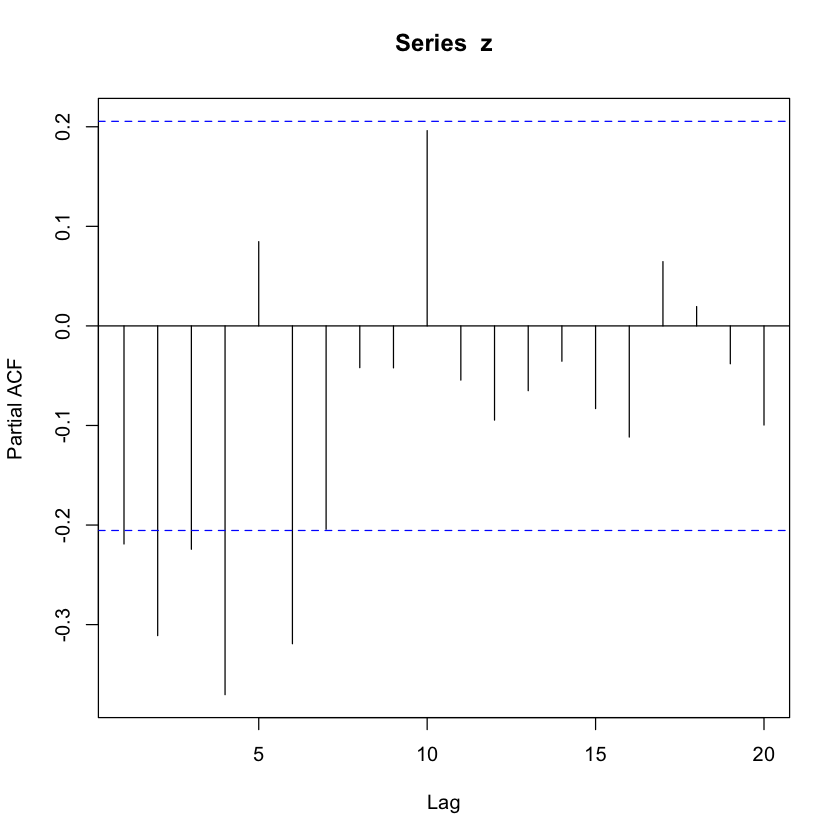

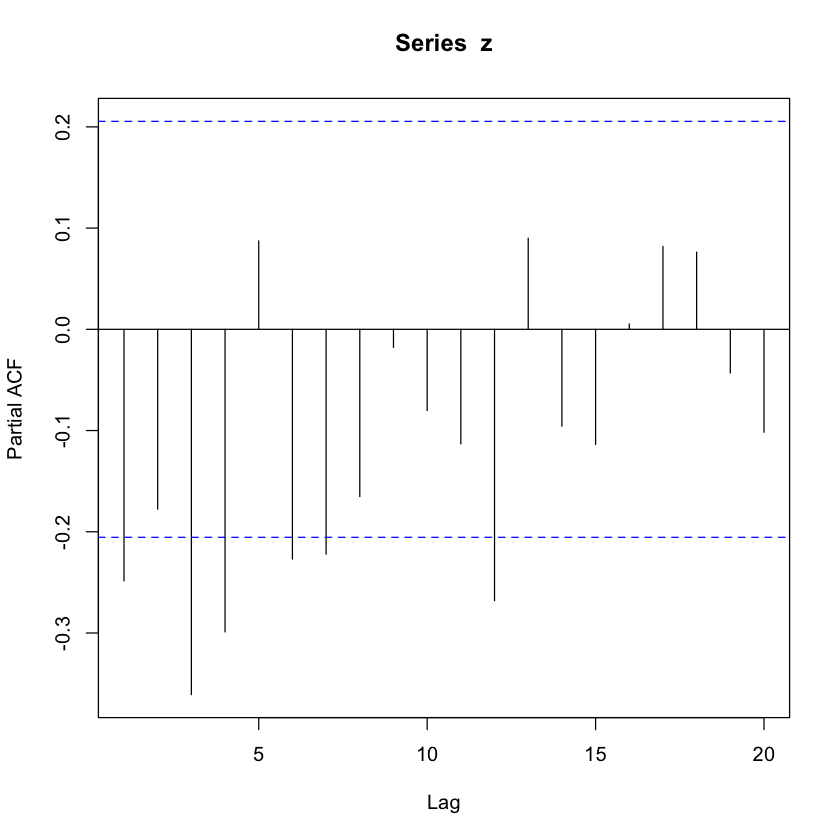

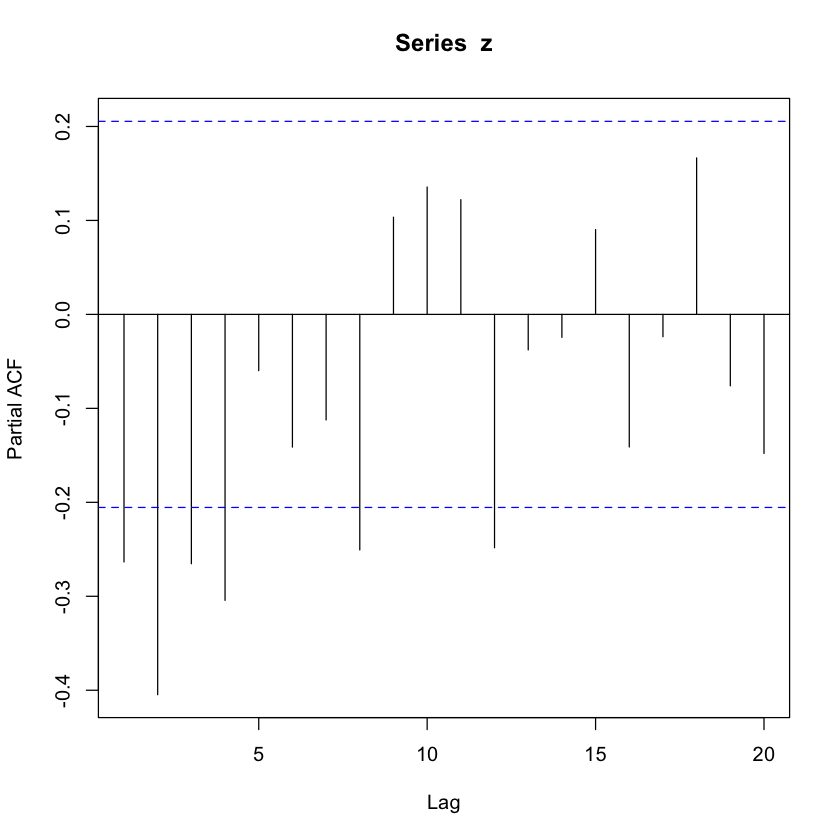

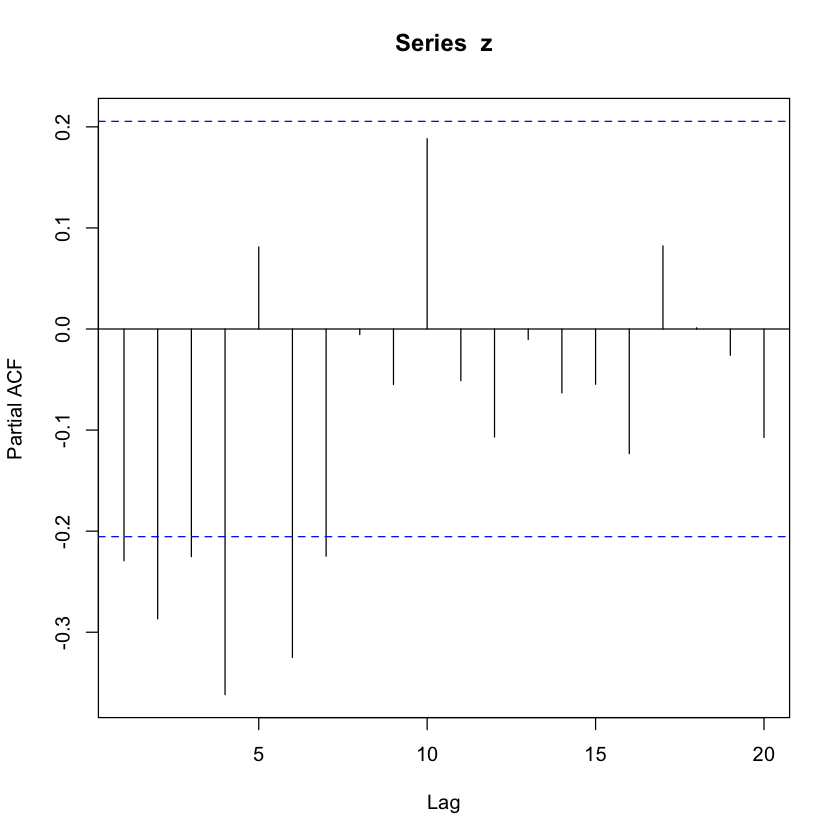

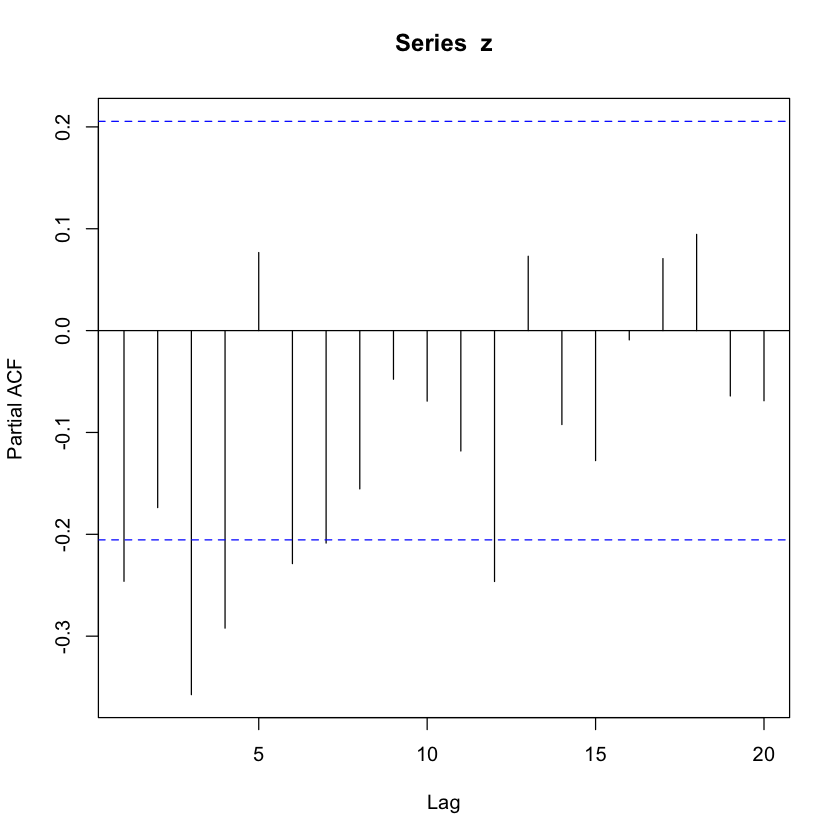

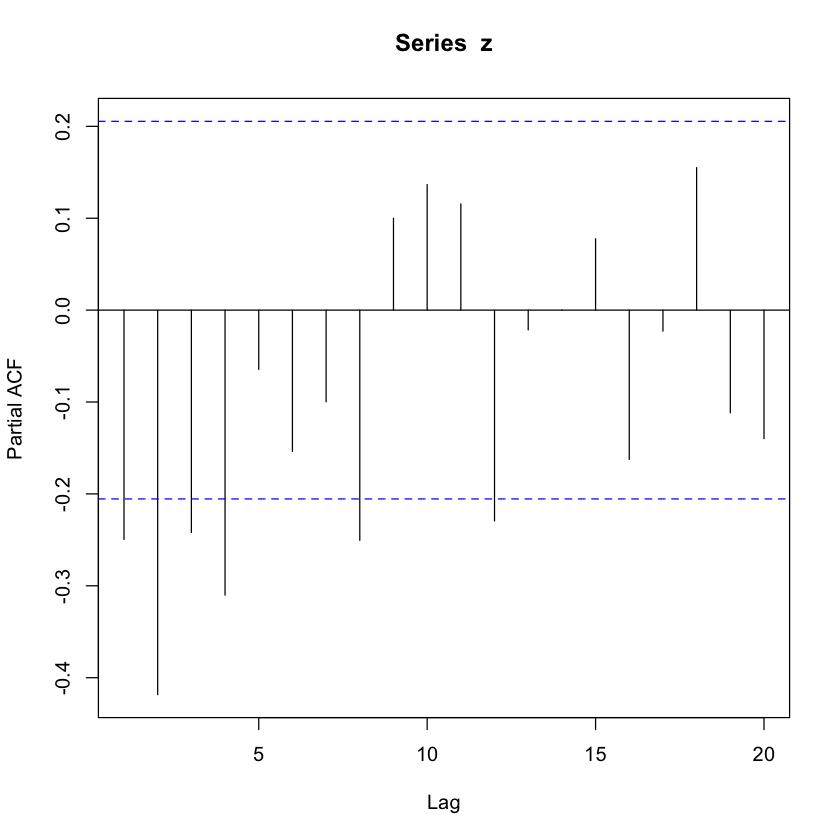

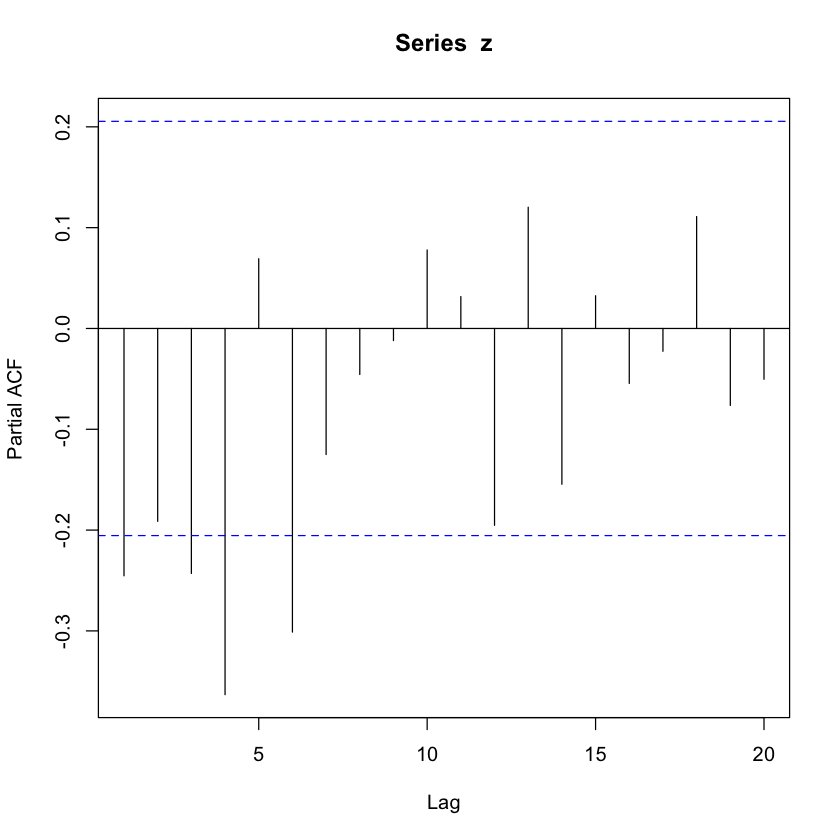

In [209]:
# X is a dataframe contatianing causes, y is cause
# first test 
# y=arsenic, index = 2
# X = boran, sulfate; index = 4,5. And turn to be 1,2 in new df
X <- cbind(data[,4],data[,5],data[,6],data[,8],data[,9],data[,10],data[,12],data[,15])
y <- data[,2]
direct <- filter_cause(X,y)

In [210]:
direct

[1] 5 2 3 6 1 4

In [150]:
arr <- c(1,2,3,4,5,6)

In [153]:
t <- remove(t,2)
t

[1] 1 3 6

In [179]:
for (i in direct) print(direct[i])

[1] 6
[1] 2
[1] 3
[1] 1
[1] 5
[1] 4


In [205]:
dim(data)

[1] 91 16